# Statistical model
1. Single LinReg
2. One LinReg per model
3. One LinReg per model but include operators in training data.

In [1]:
# Load data
from src.util import read_results
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.util import model_operators, train_and_score, train_test_validate_split, feature_transform_pipe, eval_result
import numpy as np
result_df = read_results(from_parquet=True)
result_df.head()
%load_ext autoreload
%autoreload 2
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

from src.util import all_cat_features
list_features = [x for x in result_df.columns if isinstance(result_df[x].iloc[0], np.ndarray)]
print(list_features)
result_df = result_df.drop(columns=list_features)
cat_features = list(set(result_df.columns).intersection(all_cat_features))
result_df[cat_features] = result_df[cat_features].astype(str)

train, test, validate = train_test_validate_split(result_df)
estimator_results = {}

['features', 'r_S', 'c_S', 'nnz_S', 'sparsity_S', 'morpheusfi_eis', 'morpheusfi_nis']
train set:
	Records: 189256
	Positive (speedup > 1 with factorizing)/Negative: 36554/152702 = 0.24 s
	Dataset types: ['synthetic']
\Compute Units: ['v100' '2080' 'CPU 16c' 'a40' 'CPU 08c' '1080' 'CPU 32c']
test set:
	Records: 81110
	Positive (speedup > 1 with factorizing)/Negative: 15420/65690 = 0.23 s
	Dataset types: ['synthetic']
\Compute Units: ['2080' 'CPU 08c' 'CPU 32c' 'a40' 'v100' 'CPU 16c' '1080']
validate set:
	Records: 42183
	Positive (speedup > 1 with factorizing)/Negative: 5569/36614 = 0.15 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


## Stat.1 Single LinReg


In [2]:
all_features = ['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'compute_unit', 'complexity_ratio',
       'times_mean', 'dataset_type', 'compute_type', 'label', 'features',
       'parallelism', 'mem_mat_read', 'mem_mat_write', 'mem_fac_read',
       'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat', 'comp_rmm_mat',
       'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac', 'comp_mat_col_major',
       'comp_fac_col_major', 'comp_scalar_dense', '13', '14',
       'comp_matrix_dense', 'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu__architecture', 'gpu__number_of_sm', 'gpu__cores',
       'gpu_cache_size_l1', 'gpu_cache_size_l2', 'gpu_clock_speed_base',
       'gpu_clock_speed_max_boost', 'gpu_memory_bus_width', 'gpu_memory_size',
       'gpu_memory_clock', 'gpu_memory_bandwidth',
       'gpu_processing_power_half_precision',
       'gpu_processing_power_single_precision',
       'gpu_processing_power_double_precision', 'materialized_times_mean',
       'time_saved']
meta_features = ['dataset_type', 'features', 'comp_ratio', 'tr', 'fr', 'compute_unit', 'materialized_times_mean']
dep = ['speedup', 'times_mean', 'label', 'time_saved','materialized_times_mean']
indep = list(set(all_features).intersection(result_df.columns) - set(dep) - set(meta_features))

2024-03-23 18:27:10.435 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2024-03-23 18:27:17.845 | INFO     | src.util:eval_model:470 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['comp_scalar_fac', 'r_T', 'TR', 'gpu__cores', 'comp_colsum',
       'morpheusfi_ns', 'mem_fac_wri

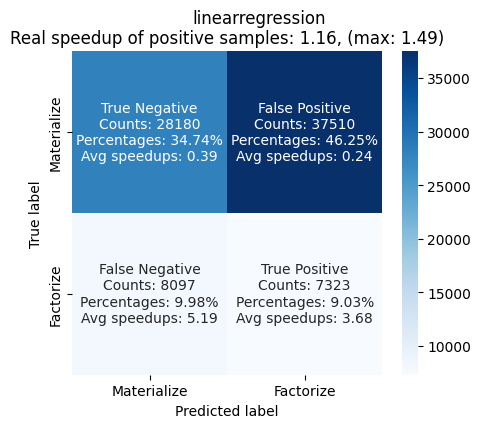

In [3]:
target_col = 'time_saved'
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]

lin_reg_combined = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True, target_col=target_col)

# Test only on models
locator = test[test.operator.isin(model_operators)].index
y_pred = pd.Series(lin_reg_combined.predict(X_test.loc[locator]), index=X_test.loc[locator].index)
resul = eval_result(y_test.loc[locator], y_pred > 1.2, full_dataset=test.loc[locator], model_name='STAT.1', target_col=target_col)

estimator_results['STAT.1'] = resul[0]

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

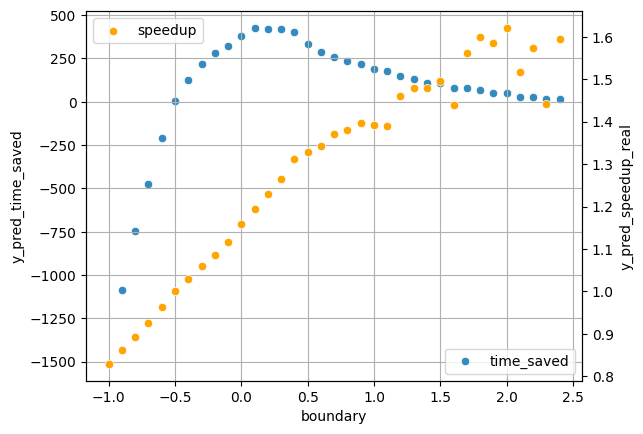

In [4]:
from src.util import eval_result

def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1, target_col=target_col):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=test, target_col=target_col)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved')
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange')
    ax.grid()
    ax.legend(loc='lower right')
    return ax
plot_boundary(y_test, pd.Series(lin_reg_combined.predict(X_test), index=X_test.index), upper=2.5, target_col=target_col)

## STAT.2 Single linreg on only Models

2024-03-23 18:27:24.362 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2024-03-23 18:27:26.024 | INFO     | src.util:eval_model:470 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['comp_scalar_fac', 'r_T', 'TR', 'gpu__cores', 'comp_colsum',
       'morpheusfi_ns', 'mem_fac_wri

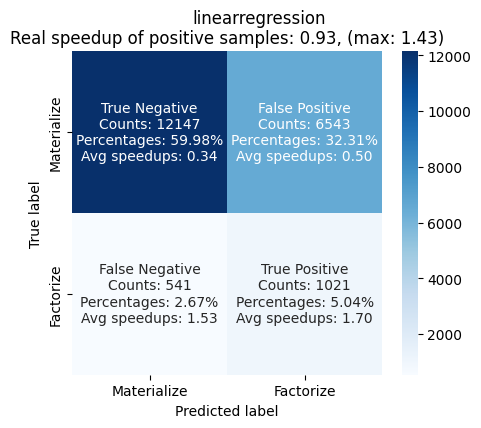

In [5]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]
lin_reg_model = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

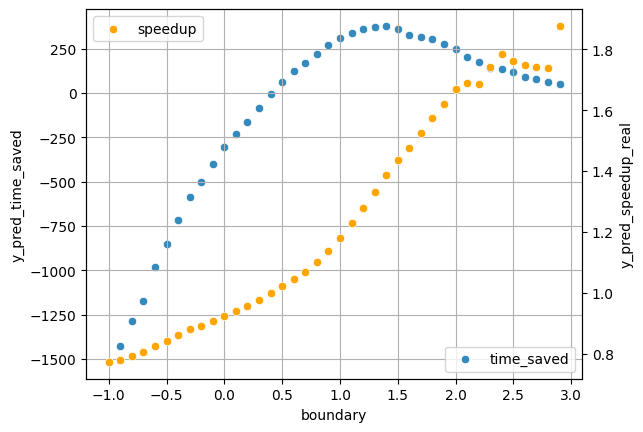

In [6]:
y_pred = pd.Series(lin_reg_model.predict(X_test), index=X_test.index)
plot_boundary(y_test, y_pred, upper=3.0)

In [7]:
estimator_results['STAT.2'] = eval_result(y_test, y_pred>1.5, full_dataset=test, model_name='STAT.2')[0]

## STAT.3 Linear Regression predict runtime for F & M
Two regression, predict runtime for both F and M. Select lowest

In [8]:
from src.analytical_model import create_linreg_ensemble, predict_linreg_ensemble


train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# Add a constant column to the dataframes
train['constant'] = 1
test['constant'] = 1
validate['constant'] = 1

X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [9]:
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='constant',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by='constant')

2024-03-23 18:27:28.591 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by constant
2024-03-23 18:27:28.602 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


2024-03-23 18:27:30.224 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:31.817 | INFO     | src.analytical_model:create_linreg_ensemble:127 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-23 18:27:31.819 | INFO     | src.analytical_model:predict_linreg_ensemble:70 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

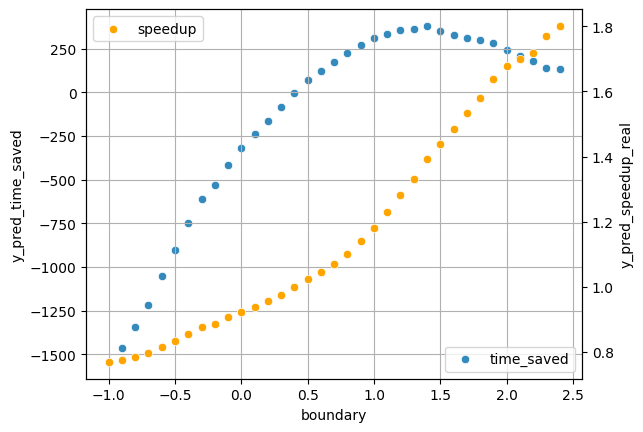

In [10]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)

In [11]:
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 1.4, full_dataset=test, target_col='time_saved')
estimator_results['STAT.3'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat.4 Separate regressors for each model type

## Stat.4 Separate regressors for each model type

In [12]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='operator',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by='operator')

2024-03-23 18:27:34.943 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by operator
2024-03-23 18:27:34.956 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-23 18:27:35.878 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:36.816 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:37.745 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:38.681 | INFO     | src.analytical_model:create_linreg_ensemble:127 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-23 18:27:38.683 | INFO     | src.analytical_model:predict_linreg_ensemble:70 - Predicting results of the analytical model using a linear regression ensemble


In [13]:
res = eval_result(y_test, y_pred = pred.time_saved, full_dataset=test)
estimator_results['STAT.4'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat. 5 split CPU and GPU

In [14]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

split_by = 'compute_type'
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by=split_by)

2024-03-23 18:27:39.218 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by compute_type
2024-03-23 18:27:39.230 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-23 18:27:40.317 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:41.723 | INFO     | src.analytical_model:create_linreg_ensemble:127 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-23 18:27:41.725 | INFO     | src.analytical_model:predict_linreg_ensemble:70 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

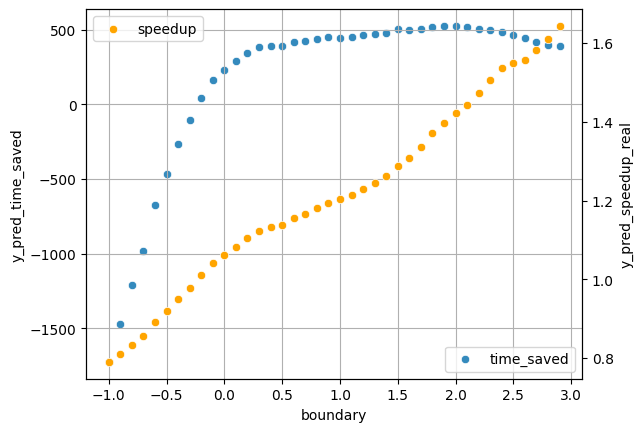

In [15]:
res = eval_result(y_test, y_pred = pred.time_saved > 0.7, full_dataset=test)
estimator_results['STAT.5'] = res[0]
res[0]
plot_boundary(y_test, pred.time_saved, upper=3.0)

## Stat.6 Split by F,M,operator

In [16]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-23 18:27:45.248 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by ['operator']
2024-03-23 18:27:45.261 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-23 18:27:46.207 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:47.179 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:48.207 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:49.166 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:50.113 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:51.055 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:51.986 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:52.912 | INFO     | src.analytical_model:create_linr

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

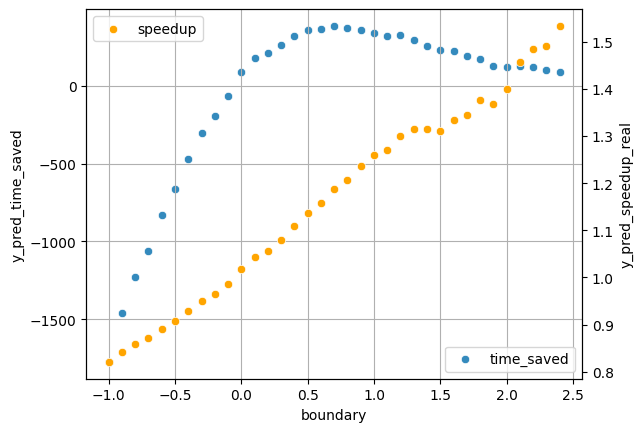

In [17]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.6, full_dataset=test, target_col='time_saved')
estimator_results['STAT.6'] = res[0]

## Stat.7 Split by F,M,operator

In [18]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator', 'compute_type']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

import pickle
with open("trained_models/stat7.pkl", "wb") as f:
    pickle.dump(linreg_f_m, f)

2024-03-23 18:27:56.154 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'compute_type']
2024-03-23 18:27:56.170 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-23 18:27:57.019 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:57.879 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:58.744 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:27:59.684 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:00.583 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:01.508 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:02.506 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:03.635 | INFO     | src.util:feature_transform_pipe:

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

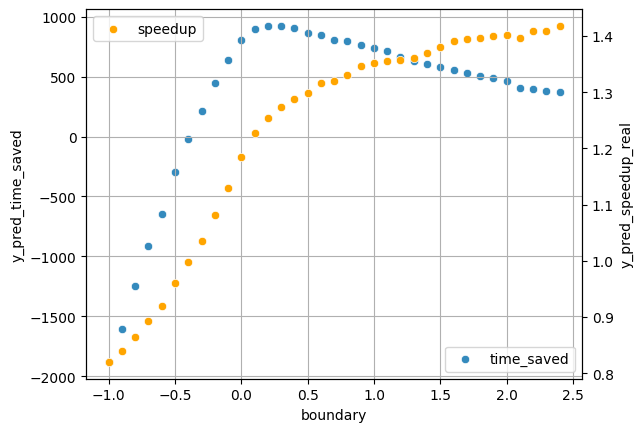

In [19]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
estimator_results['STAT.7'] = res[0]

## STAT.8 (not included)

In [20]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['compute_type']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-23 18:28:14.409 | INFO     | src.analytical_model:create_linreg_ensemble:101 - Creating a linear regression ensemble for the analytical model, splitting by ['compute_type']
2024-03-23 18:28:14.423 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-23 18:28:15.532 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:16.666 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:18.214 | INFO     | src.util:feature_transform_pipe:434 - ['join', 'operator', 'compute_type', 'gpu__architecture']
2024-03-23 18:28:19.472 | INFO     | src.analytical_model:create_linreg_ensemble:127 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-23 18:28:19.474 | INFO     | src.analytical_model:predict_linreg_ensemble:70 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:488: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

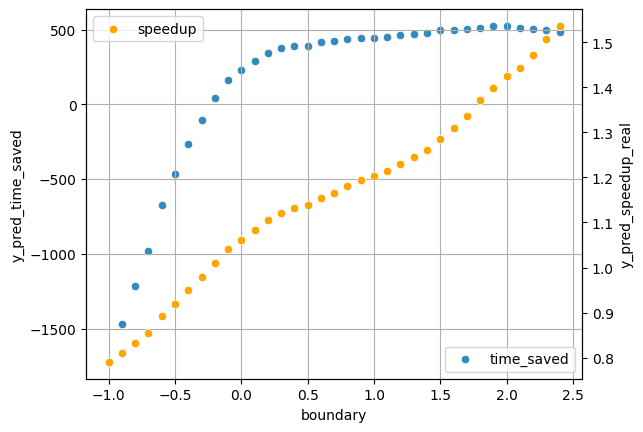

In [21]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
# estimator_results['STAT.8'] = res[0]

# Analysis

In [22]:
import matplotlib
colors = ['#F5F5F5', '#DAE8FC', '#D5E8D4', '#FFE6CC', '#FFF2CC','#F8CECC', '#E1D5E7']
pal = sns.color_palette([matplotlib.colors.to_rgba(x) for x in colors])
pal

[(0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
 (0.8549019607843137, 0.9098039215686274, 0.9882352941176471),
 (0.8352941176470589, 0.9098039215686274, 0.8313725490196079),
 (1.0, 0.9019607843137255, 0.8),
 (1.0, 0.9490196078431372, 0.8),
 (0.9725490196078431, 0.807843137254902, 0.8),
 (0.8823529411764706, 0.8352941176470589, 0.9058823529411765)]

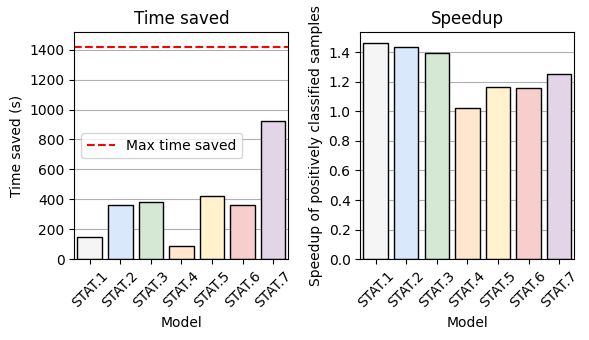

In [32]:
resdf = pd.DataFrame(estimator_results.values())
resdf['Model'] = estimator_results.keys()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
palette = []
f, axs = plt.subplots(1,2, figsize=(6,3.5))
labels = ["Time saved (s)", "Speedup of positively classified samples"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf.y_true_time_saved.max()
max_speedup = resdf.y_pred_speedup_real.max()
for ax, var, label, title in zip(axs, ['y_pred_time_saved', 'y_pred_speedup_real'], labels, titles):
    sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    # ax.set_xlabel("Cost Model")
    ax.set_title(title)
    if var =='y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved")
        ax.set_ylim(top=max_time_saved+100)
        ax.legend()
    elif var == 'y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max speedup")
        ax.legend()
    
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/stat-models-compare.pdf", bbox_inches='tight')

In [24]:
resdf

,accuracy,precision,recall,f1,speedup,r2,mean_squared_error,Model,y_true_mat_time,y_true_fact_time,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.918227,0.334728,0.050063,0.087099,"{'y_true_mat_time': 4766.433451637602, 'y_true...",NaN,NaN,STAT.1,4766.433452,3374.823689,...,322.337528,305.119902,148.413573,1.111640,1.460429,"(80, 1.7313097491037936)","(159, 0.7998571546298218)","(18751, 0.3945597997152604)","(1518, 1.6320106624043966)",0.106649
1,0.917737,0.446058,0.275288,0.340459,"{'y_true_mat_time': 4733.428332464589, 'y_true...",NaN,NaN,STAT.2,4733.428332,3317.907400,...,827.920161,773.699905,362.261688,1.075253,1.437556,"(430, 1.6489511177177447)","(534, 0.6132860673742251)","(18156, 0.387667717930578)","(1132, 1.6412354829152187)",0.255921
2,0.869247,0.069048,0.055698,0.061658,"{'y_true_mat_time': 4733.428332464589, 'y_true...",NaN,NaN,STAT.3,4733.428332,3317.907400,...,969.910363,895.050795,379.661377,0.972651,1.391440,"(492, 1.613740651741676)","(768, 0.5619534419378834)","(17922, 0.38692163839510746)","(1070, 1.6569786417025727)",0.268213
3,0.690203,0.075036,0.266325,0.117084,"{'y_true_mat_time': 4733.428332464589, 'y_true...",-0.806338,21.267447,STAT.4,4733.428332,3317.907400,...,4594.320723,3650.708968,87.347309,0.717355,1.019012,"(1044, 1.6140772601550324)","(4500, 0.509315654943922)","(14190, 0.3575806483071009)","(518, 1.7023762310363002)",0.061707
4,0.850237,0.078993,0.088348,0.083409,"{'y_true_mat_time': 4733.428332464589, 'y_true...",NaN,NaN,STAT.5,4733.428332,3317.907400,...,2568.363197,2283.930154,423.508743,1.053963,1.164894,"(738, 1.5614780431164192)","(1009, 0.6827585639397877)","(17681, 0.37764190123353686)","(824, 1.7166950867217714)",0.299189
5,0.853052,0.078162,0.083867,0.080914,"{'y_true_mat_time': 4733.428332464589, 'y_true...",NaN,NaN,STAT.6,4733.428332,3317.907400,...,2293.850548,1920.886137,362.071302,0.860562,1.157844,"(513, 1.651320828951139)","(1163, 0.5117574525709814)","(17527, 0.38630774972244875)","(1049, 1.639466122046447)",0.255787
6,0.832214,0.076177,0.105634,0.088519,"{'y_true_mat_time': 4733.428332464589, 'y_true...",NaN,NaN,STAT.7,4733.428332,3317.907400,...,3639.006058,3320.362435,922.124247,1.166927,1.253400,"(1062, 1.769324460380971)","(1104, 0.5874461721629954)","(17586, 0.3819770995483603)","(500, 1.3758099407081321)",0.651438
